In [21]:
import sys
sys.path.append('/notebooks/pytorch_timeseries')

import datetime
from enum import Enum
import json
import os
import random
import re
import signal
import threading
import time
import hashlib
from prettytable import PrettyTable
import sys
####
from typing import Dict, List, Type, Union
import numpy as np
import torch
from torchmetrics import MeanSquaredError, MetricCollection, MeanAbsoluteError, MeanAbsolutePercentageError
from tqdm import tqdm
import wandb
from torch_timeseries.data.scaler import *
from torch_timeseries.datasets import *
from torch_timeseries.experiments.experiment import Experiment

from torch_timeseries.datasets.dataset import TimeSeriesDataset
from torch_timeseries.datasets.splitter import SequenceRandomSplitter, SequenceSplitter
from torch_timeseries.datasets.dataloader import (
    ChunkSequenceTimefeatureDataLoader,
    DDPChunkSequenceTimefeatureDataLoader,
)
from torch_timeseries.datasets.wrapper import MultiStepTimeFeatureSet
from torch_timeseries.models.Informer import Informer
from torch.nn import MSELoss, L1Loss

from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset

from torch.nn import DataParallel
import torch.nn as nn
from dataclasses import asdict,dataclass

from torch_timeseries.nn.metric import R2, Corr, TrendAcc,RMSE, compute_corr, compute_r2
from torch_timeseries.metrics.masked_mape import MaskedMAPE
from torch_timeseries.utils.early_stopping import EarlyStopping
import json
import codecs

import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from class_resolver.contrib.torch import activation_resolver
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn import FAConv,HeteroConv
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear


from torch_timeseries.layers.tcn_output8 import TCNOuputLayer

In [85]:
%load_ext autoreload
%autoreload 2

from torch_geometric.utils import dense_to_sparse

from torch_timeseries.models import NLinear




class Model(nn.Module):
    def __init__(self, seq_len, pred_len, num_features, device, individual=False, normalization=True):
        super(Model, self).__init__()
        # inputs:
        # batch_x: (B, N, T)
        
        
        hidden_dim = 16
        self.num_features = num_features
        self.normalization = normalization
        self.linears = nn.ModuleList()
        
        for i in range(num_features):
            self.linears.append(
                nn.Sequential(
                    nn.Linear(seq_len, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, pred_len),
                )
            )
    
    def forward(self, x):
        # batch_x: (B, N, T)
        # out: (B, N, O)
        if self.normalization:
            seq_last = x[:,:,-1:].detach()
            x = x - seq_last

        # 计算最后一个维度的均值和标准差
        # mean = x.mean(dim=2, keepdim=True).detach()
        # std = x.std(dim=2, keepdim=True)

        # # 标准化处理：最后一个维度减去均值，然后除以标准差
        # x = (x - mean) / std

        xs = []
        for i in range(self.num_features):
            xs.append(self.linears[i](x[:, i, :])) # x[:, i, :] =  
        x = torch.stack(xs, dim=1)
        
        if self.normalization:
            x = x + seq_last
        # x = x + mean
        return x
    
    
    
@dataclass
class ModelExperiment(Experiment):
    normalization : bool = True
    def _process_model1_train(self, batch_x, batch_y, batch_x_date_enc, batch_y_date_enc):
        # inputs:
        # batch_x: (B, T, N)
        # batch_y: (B, O, N)
        # ouputs:
        # - pred: (B, N)/(B, O, N)
        # - label: (B, N)/(B, O, N)
        batch_size = batch_x.size(0)
        batch_x = batch_x.to(self.device, dtype=torch.float32)
        batch_y = batch_y.to(self.device, dtype=torch.float32)
        batch_x_date_enc = batch_x_date_enc.to(self.device).float()
        batch_y_date_enc = batch_y_date_enc.to(self.device).float()
        
        # print(batch_x.shape, self.model1.num)
        batch_x = batch_x.transpose(1,2)
        
        
        prior_y = self.model1(batch_x)
        # batch_x = batch_x
        # outputs = self.model.inference_predict(batch_x)  # torch.Size([batch_size, num_nodes])
        # single step prediction
        return prior_y, batch_y.transpose(1,2)

    def _process_model2_train(self, batch_x, batch_y, prior_y, batch_x_date_enc, batch_y_date_enc):
        # inputs:
        # prior_y: (B, N, O)
        # ouputs:
        # - pred: (B, N)/(B, O, N)
        # - label: (B, N)/(B, O, N)
        y = self.model2(prior_y)  # torch.Size([batch_size, num_nodes])
        # single step prediction
        return y
    def count_parameters(self, print_fun):
        total_params = 0
        for name, parameter in self.model1.named_parameters():
            if not parameter.requires_grad:
                continue
            params = parameter.numel()
            total_params += params
            
        for name, parameter in self.model2.named_parameters():
            if not parameter.requires_grad:
                continue
            params = parameter.numel()
            total_params += params
        print_fun(f"Total Trainable Params: {total_params}")
        return total_params
    


    def _evaluate(self, dataloader):
        self.model1.eval()
        self.model2.eval()
        self.metrics.reset()
        
        length = 0
        if dataloader is self.train_loader:
            length = self.dataloader.train_size
        elif dataloader is self.val_loader:
            length = self.dataloader.val_size
        elif dataloader is self.test_loader:
            length = self.dataloader.test_size

        # y_truths = []
        # y_preds = []
        with torch.no_grad():
            with tqdm(total=length) as progress_bar:
                for batch_x, batch_y,batch_origin_y, batch_x_date_enc, batch_y_date_enc in dataloader:
                    batch_size = batch_x.size(0)
                    prior_y , truths = self._process_model1_train(
                        batch_x, batch_y, batch_x_date_enc, batch_y_date_enc
                    )
                    preds = self._process_model2_train(
                        batch_x, batch_y,prior_y.transpose(1,2).detach(), batch_x_date_enc, batch_y_date_enc
                    ).transpose(1,2)
                    # the result should be the same
                    # self.metrics.update(preds.view(batch_size, -1), truths.view(batch_size, -1))
                    # import pdb;pdb.set_trace()
                    batch_origin_y = batch_origin_y.to(self.device)
                    if self.invtrans_loss:
                        preds = self.scaler.inverse_transform(preds)
                        truths = batch_origin_y

                    if self.pred_len == 1:
                        self.metrics.update(prior_y.view(batch_size, -1), truths.view(batch_size, -1))
                    else:
                        self.metrics.update(prior_y.contiguous(), truths.contiguous())

                    progress_bar.update(batch_x.shape[0])

            result = {
                name: float(metric.compute()) for name, metric in self.metrics.items()
            }
        return result


    def _init_model(self):
        
        self.model1 = Model(
            seq_len=self.windows,
            pred_len=self.pred_len,
            num_features=self.dataset.num_features,
            device=self.device,
            normalization=self.normalization,
        ).to(self.device)
        
        self.model2 = Model(
            seq_len=self.dataset.num_features,
            pred_len=self.dataset.num_features,
            num_features=self.pred_len,
            device=self.device,
             normalization=False
        ).to(self.device)
        self.model = nn.ModuleDict({
            'prior': self.model1,
            'post': self.model2,
        })

        self.loss_func = torch.nn.MSELoss()

    def _init_optimizer(self):
        self.model1_optim = Adam(
            self.model1.parameters(), lr=self.lr, weight_decay=self.l2_weight_decay
        )
        
        self.model2_optim = Adam(
            self.model2.parameters(), lr=self.lr, weight_decay=self.l2_weight_decay
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.model1_optim , T_max=self.epochs
        )


    def run(self, seed=42) -> Dict[str, float]:
        if hasattr(self, "finished") and self.finished is True:
            print("Experiment finished!!!")
            return {}

        self._setup_run(seed)
        if self._check_run_exist(seed):
            self._resume_run(seed)

        self._run_print(f"run : {self.current_run} in seed: {seed}")
        
        self.model_parameters_num = self.count_parameters(self._run_print)
        self._run_print(
            f"model parameters: {self.model_parameters_num}"
        )
        if self._use_wandb():
            wandb.run.summary["parameters"] = self.model_parameters_num
        # for resumable reproducibility

        epoch_time = time.time()
        while self.current_epoch < self.epochs:
            if self.early_stopper.early_stop is True:
                self._run_print(
                    f"loss no decreased for {self.patience} epochs,  early stopping ...."
                )
                break

            if self._use_wandb():
                wandb.run.summary["at_epoch"] = self.current_epoch
            # for resumable reproducibility
            self.reproducible(seed + self.current_epoch)
            train_losses =  self._train()

            self._run_print(
                "Epoch: {} cost time: {}".format(
                    self.current_epoch + 1, time.time() - epoch_time
                )
            )
            self._run_print(
                f"Traininng loss : {np.mean(train_losses)}"
            )

            # self._run_print(f"Val on train....")
            # trian_val_result = self._evaluate(self.train_loader)
            # self._run_print(f"Val on train result: {trian_val_result}")
            
            # evaluate on val set
            result = self._val()
            # test
            test_result = self._test()

            self.current_epoch = self.current_epoch + 1
            self.early_stopper(result[self.loss_func_type], model=self.model2)
            
            self._save_run_check_point(seed)

            self.scheduler.step()
            
            # if self._use_wandb():
            #     wandb.log(result, step=self.current_epoch)



        self._load_best_model()
        best_test_result = self._test()
        self.run_setuped = False
        return best_test_result

    def _save_run_check_point(self, seed):
        # 检查目录是否存在
        if not os.path.exists(self.run_save_dir):
            # 如果目录不存在，则创建新目录
            os.makedirs(self.run_save_dir)
        print(f"Saving run checkpoint to '{self.run_save_dir}'.")

        self.run_state = {
            "model": self.model.state_dict(),
            "current_epoch": self.current_epoch,
            # "optimizer": self.model_optim.state_dict(),
            "rng_state": torch.get_rng_state(),
            "early_stopping": self.early_stopper.get_state(),
        }

        torch.save(self.run_state, f"{self.run_checkpoint_filepath}")
        print("Run state saved ... ")

    def _train(self):
        with torch.enable_grad(), tqdm(total=self.train_steps) as progress_bar:
            self.model1.train()
            self.model2.train()
            train_loss = []
            for i, (
                batch_x,
                batch_y,
                origin_y,
                batch_x_date_enc,
                batch_y_date_enc,
            ) in enumerate(self.train_loader):
                origin_y = origin_y.to(self.device)
                self.model1_optim.zero_grad()
                self.model2_optim.zero_grad()
                prior_y , true = self._process_model1_train(
                    batch_x, batch_y, batch_x_date_enc, batch_y_date_enc
                )
                prior_y.retain_grad()
                pred = self._process_model2_train(
                    batch_x, batch_y,prior_y.transpose(1,2).detach(), batch_x_date_enc, batch_y_date_enc
                ).transpose(1,2)
                if self.invtrans_loss:
                    prior_y = self.scaler.inverse_transform(prior_y)
                    pred = self.scaler.inverse_transform(pred)
                    true = origin_y
                
                loss1 = self.loss_func(prior_y, true)
                
                loss2 = self.loss_func(pred, true)
                
                loss1.backward()
                loss2.backward()
                # if i*self.batch_size >= 1000:
                #     import pdb;pdb.set_trace()
                
                # grad_adjust(prior_y)

                # torch.nn.utils.clip_grad_norm_(
                #     self.model1.parameters(), self.max_grad_norm
                # )
                progress_bar.update(batch_x.size(0))
                train_loss.append(loss1.item())
                progress_bar.set_postfix(
                    epoch=self.current_epoch,
                    refresh=True,
                )

                self.model1_optim.step()
                self.model2_optim.step()
            return train_loss


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
def grad_adjust(tensor_):
    grad = tensor_.grad

    # 计算梯度的平均值
    abs_grad_mean = abs(grad).mean(1, keepdim=True)
    
    # ratio = 1 - torch.functional.F.softmax(abs(grad), dim=1)
    diff = abs_grad_mean/grad
    # 计算每个梯度与平均值的差异比例
    # 注意：为避免除以0，可以添加一个小的epsilon值
    # epsilon = 0
    # weights = (grad - grad_mean) / (grad.std() + epsilon)
    
    # import pdb;pdb.set_trace()
    
    # 根据差异调整梯度的大小
    # 这里可以根据需要调整比例因子，例如，让差异更加显著
    adjusted_grad = grad * diff
    tensor_.grad = adjusted_grad


In [88]:
exp = ModelExperiment(
    # dataset_type="SP500",
    model_type ="test3",
    normalization=True,
    dataset_type="DummyContinuous",
    horizon=24,
    pred_len=1,
    data_path='/notebooks/pytorch_timeseries/data/',
    windows=40,
    
)

exp.run(3)

train steps: 1953
val steps: 513
test steps: 226
torch.get_default_dtype() torch.float32
Creating running results saving dir: './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
run : 0 in seed: 3
Total Trainable Params: 722
model parameters: 722
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 586.65it/s, epoch=0] 


Epoch: 1 cost time: 3.335577964782715
Traininng loss : 0.08210194200998353
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 158.04it/s]


vali_results: {'corr': 0.9999981741681089, 'mae': 0.23408232629299164, 'mse': 0.05479474365711212, 'r2': -3.323676586151123, 'r2_weighted': -3.323676586151123}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 90.09it/s]


test_results: {'corr': 0.9999956208953753, 'mae': 0.2328750342130661, 'mse': 0.05423080921173096, 'r2': -25.177156448364258, 'r2_weighted': -25.177156448364258}
Validation loss decreased (inf --> 0.054795).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 557.62it/s, epoch=1] 


Epoch: 2 cost time: 12.62612771987915
Traininng loss : 0.048435354845658425
Evaluating .... 


100%|██████████| 513/513 [00:02<00:00, 186.66it/s]


vali_results: {'corr': 0.9999982438214263, 'mae': 0.18088117241859436, 'mse': 0.03271801024675369, 'r2': -1.5816729068756104, 'r2_weighted': -1.5816729068756104}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 105.47it/s]


test_results: {'corr': 0.9999955308092704, 'mae': 0.18048469722270966, 'mse': 0.03257473185658455, 'r2': -14.723790168762207, 'r2_weighted': -14.723790168762207}
Validation loss decreased (0.054795 --> 0.032718).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 487.53it/s, epoch=2] 


Epoch: 3 cost time: 21.55233097076416
Traininng loss : 0.02674412165558146
Evaluating .... 


100%|██████████| 513/513 [00:02<00:00, 192.26it/s]


vali_results: {'corr': 0.9999982888624355, 'mae': 0.13671191036701202, 'mse': 0.018690159544348717, 'r2': -0.47478020191192627, 'r2_weighted': -0.47478020191192627}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 87.90it/s]


test_results: {'corr': 0.999995673434142, 'mae': 0.13703185319900513, 'mse': 0.01877773180603981, 'r2': -8.063992500305176, 'r2_weighted': -8.063992500305176}
Validation loss decreased (0.032718 --> 0.018690).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 550.96it/s, epoch=3] 


Epoch: 4 cost time: 30.3757963180542
Traininng loss : 0.013312761055966538
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 159.17it/s]


vali_results: {'corr': 0.9999981937993828, 'mae': 0.09738916903734207, 'mse': 0.009484782814979553, 'r2': 0.251586377620697, 'r2_weighted': 0.251586377620697}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 87.20it/s]


test_results: {'corr': 0.9999957091650877, 'mae': 0.09833559393882751, 'mse': 0.009669902734458447, 'r2': -3.6676526069641113, 'r2_weighted': -3.6676526069641113}
Validation loss decreased (0.018690 --> 0.009485).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 536.96it/s, epoch=4] 


Epoch: 5 cost time: 39.886497020721436
Traininng loss : 0.005523001895316185
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 143.38it/s]


vali_results: {'corr': 0.9999982286140996, 'mae': 0.06571672856807709, 'mse': 0.004319010302424431, 'r2': 0.6592007875442505, 'r2_weighted': 0.6592007875442505}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 91.32it/s]


test_results: {'corr': 0.9999955834029948, 'mae': 0.0671856701374054, 'mse': 0.004513951018452644, 'r2': -1.1788794994354248, 'r2_weighted': -1.1788794994354248}
Validation loss decreased (0.009485 --> 0.004319).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 524.44it/s, epoch=5] 


Epoch: 6 cost time: 49.70011758804321
Traininng loss : 0.0020845494056571153
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 144.32it/s]


vali_results: {'corr': 0.9999982098335882, 'mae': 0.04449763149023056, 'mse': 0.001980513334274292, 'r2': 0.8437240719795227, 'r2_weighted': 0.8437240719795227}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 94.51it/s]


test_results: {'corr': 0.9999954974957405, 'mae': 0.04627953842282295, 'mse': 0.002141849836334586, 'r2': -0.03386878967285156, 'r2_weighted': -0.03386878967285156}
Validation loss decreased (0.004319 --> 0.001981).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 506.84it/s, epoch=6] 


Epoch: 7 cost time: 59.53657102584839
Traininng loss : 0.0009834728862774828
Evaluating .... 


100%|██████████| 513/513 [00:02<00:00, 174.89it/s]


vali_results: {'corr': 0.9999982771899835, 'mae': 0.03258715942502022, 'mse': 0.0010624617571011186, 'r2': 0.9161645770072937, 'r2_weighted': 0.9161645770072937}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 86.70it/s]


test_results: {'corr': 0.9999956247709414, 'mae': 0.03448819741606712, 'mse': 0.0011894971830770373, 'r2': 0.4258309006690979, 'r2_weighted': 0.4258309006690979}
Validation loss decreased (0.001981 --> 0.001062).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 469.01it/s, epoch=7] 


Epoch: 8 cost time: 69.2760751247406
Traininng loss : 0.0006358164199252403
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 169.40it/s]


vali_results: {'corr': 0.9999982268649515, 'mae': 0.026258571073412895, 'mse': 0.0006900464650243521, 'r2': 0.9455506801605225, 'r2_weighted': 0.9455506801605225}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 87.16it/s]


test_results: {'corr': 0.9999955285141292, 'mae': 0.028150586411356926, 'mse': 0.0007925165700726211, 'r2': 0.6174530982971191, 'r2_weighted': 0.6174530982971191}
Validation loss decreased (0.001062 --> 0.000690).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 523.95it/s, epoch=8] 


Epoch: 9 cost time: 78.65269088745117
Traininng loss : 0.000499525781995016
Evaluating .... 


100%|██████████| 513/513 [00:02<00:00, 183.55it/s]


vali_results: {'corr': 0.9999982359804409, 'mae': 0.022825587540864944, 'mse': 0.000521504320204258, 'r2': 0.9588497877120972, 'r2_weighted': 0.9588497877120972}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 85.04it/s]


test_results: {'corr': 0.9999954581324395, 'mae': 0.024650925770401955, 'mse': 0.0006077249418012798, 'r2': 0.7066518068313599, 'r2_weighted': 0.7066518068313599}
Validation loss decreased (0.000690 --> 0.000522).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 501.40it/s, epoch=9] 


Epoch: 10 cost time: 88.0276780128479
Traininng loss : 0.0004086290552344684
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 143.10it/s]


vali_results: {'corr': 0.999998130477369, 'mae': 0.02046477608382702, 'mse': 0.0004192576452624053, 'r2': 0.9669177532196045, 'r2_weighted': 0.9669177532196045}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 84.11it/s]


test_results: {'corr': 0.9999957186245759, 'mae': 0.022202540189027786, 'mse': 0.0004930041031911969, 'r2': 0.762027382850647, 'r2_weighted': 0.762027382850647}
Validation loss decreased (0.000522 --> 0.000419).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 452.61it/s, epoch=10] 


Epoch: 11 cost time: 98.66810703277588
Traininng loss : 0.00033740781861612754
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 141.71it/s]


vali_results: {'corr': 0.9999982639023192, 'mae': 0.01847291737794876, 'mse': 0.0003416538820602, 'r2': 0.9730411767959595, 'r2_weighted': 0.9730411767959595}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 77.53it/s]


test_results: {'corr': 0.9999956318095533, 'mae': 0.0201208908110857, 'mse': 0.00040489656385034323, 'r2': 0.8045568466186523, 'r2_weighted': 0.8045568466186523}
Validation loss decreased (0.000419 --> 0.000342).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 518.18it/s, epoch=11] 


Epoch: 12 cost time: 109.02230978012085
Traininng loss : 0.00027766328123341794
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 138.62it/s]


vali_results: {'corr': 0.9999981217802335, 'mae': 0.016833633184432983, 'mse': 0.0002837286447174847, 'r2': 0.9776118993759155, 'r2_weighted': 0.9776118993759155}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 89.45it/s]


test_results: {'corr': 0.9999956073031118, 'mae': 0.018381327390670776, 'mse': 0.00033791392343118787, 'r2': 0.8368892669677734, 'r2_weighted': 0.8368892669677734}
Validation loss decreased (0.000342 --> 0.000284).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 484.12it/s, epoch=12] 


Epoch: 13 cost time: 119.3306028842926
Traininng loss : 0.00022719911927167907
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 146.65it/s]


vali_results: {'corr': 0.9999982540192878, 'mae': 0.015304053202271461, 'mse': 0.00023452963796444237, 'r2': 0.9814940094947815, 'r2_weighted': 0.9814940094947815}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 78.72it/s]


test_results: {'corr': 0.9999955883576619, 'mae': 0.016758281737565994, 'mse': 0.0002808759454637766, 'r2': 0.8644214868545532, 'r2_weighted': 0.8644214868545532}
Validation loss decreased (0.000284 --> 0.000235).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 536.14it/s, epoch=13] 


Epoch: 14 cost time: 129.42688393592834
Traininng loss : 0.00018557110935592304
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 137.30it/s]


vali_results: {'corr': 0.9999982389532689, 'mae': 0.013972398824989796, 'mse': 0.00019550436991266906, 'r2': 0.9845733642578125, 'r2_weighted': 0.9845733642578125}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 94.21it/s]


test_results: {'corr': 0.9999956012846146, 'mae': 0.015333367511630058, 'mse': 0.000235143699683249, 'r2': 0.886496365070343, 'r2_weighted': 0.886496365070343}
Validation loss decreased (0.000235 --> 0.000196).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 497.26it/s, epoch=14] 


Epoch: 15 cost time: 139.54763889312744
Traininng loss : 0.0001502562205249917
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 143.95it/s]


vali_results: {'corr': 0.99999821675252, 'mae': 0.012428955174982548, 'mse': 0.00015472256927751005, 'r2': 0.9877913594245911, 'r2_weighted': 0.9877913594245911}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 100.15it/s]


test_results: {'corr': 0.9999955692307453, 'mae': 0.013706435449421406, 'mse': 0.0001878940820461139, 'r2': 0.9093037247657776, 'r2_weighted': 0.9093037247657776}
Validation loss decreased (0.000196 --> 0.000155).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 510.62it/s, epoch=15] 


Epoch: 16 cost time: 149.22716617584229
Traininng loss : 0.00011751706229152924
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 136.55it/s]


vali_results: {'corr': 0.999998280803618, 'mae': 0.011167766526341438, 'mse': 0.00012493145186454058, 'r2': 0.9901420474052429, 'r2_weighted': 0.9901420474052429}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 98.31it/s]


test_results: {'corr': 0.999995625539823, 'mae': 0.012360687367618084, 'mse': 0.00015281079686246812, 'r2': 0.9262383580207825, 'r2_weighted': 0.9262383580207825}
Validation loss decreased (0.000155 --> 0.000125).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 456.52it/s, epoch=16] 


Epoch: 17 cost time: 159.62754821777344
Traininng loss : 9.238398257777237e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 159.00it/s]


vali_results: {'corr': 0.9999982452701983, 'mae': 0.009945731610059738, 'mse': 9.910160588333383e-05, 'r2': 0.9921802282333374, 'r2_weighted': 0.9921802282333374}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 81.51it/s]


test_results: {'corr': 0.9999955626291903, 'mae': 0.01105722039937973, 'mse': 0.00012228313426021487, 'r2': 0.9409740567207336, 'r2_weighted': 0.9409740567207336}
Validation loss decreased (0.000125 --> 0.000099).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 492.02it/s, epoch=17] 


Epoch: 18 cost time: 169.6936674118042
Traininng loss : 7.016093334846852e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 160.59it/s]


vali_results: {'corr': 0.9999982599318987, 'mae': 0.008775006979703903, 'mse': 7.716114487266168e-05, 'r2': 0.9939114451408386, 'r2_weighted': 0.9939114451408386}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 83.82it/s]


test_results: {'corr': 0.9999956108216588, 'mae': 0.00981115736067295, 'mse': 9.62770645855926e-05, 'r2': 0.9535271525382996, 'r2_weighted': 0.9535271525382996}
Validation loss decreased (0.000099 --> 0.000077).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 559.40it/s, epoch=18] 


Epoch: 19 cost time: 179.144216299057
Traininng loss : 4.827693177386179e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 138.73it/s]


vali_results: {'corr': 0.999998191267687, 'mae': 0.0074167135171592236, 'mse': 5.5149448598967865e-05, 'r2': 0.9956483244895935, 'r2_weighted': 0.9956483244895935}
Testing .... 


100%|██████████| 226/226 [00:03<00:00, 74.05it/s]


test_results: {'corr': 0.9999955585680539, 'mae': 0.008390854112803936, 'mse': 7.042255310807377e-05, 'r2': 0.9660071134567261, 'r2_weighted': 0.9660071134567261}
Validation loss decreased (0.000077 --> 0.000055).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 536.16it/s, epoch=19] 


Epoch: 20 cost time: 189.6317479610443
Traininng loss : 3.5484768960163964e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 164.56it/s]


vali_results: {'corr': 0.9999982791708364, 'mae': 0.006368095055222511, 'mse': 4.0677190554561093e-05, 'r2': 0.9967902898788452, 'r2_weighted': 0.9967902898788452}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 80.74it/s]


test_results: {'corr': 0.9999956422280594, 'mae': 0.007280962076038122, 'mse': 5.302655335981399e-05, 'r2': 0.9744041562080383, 'r2_weighted': 0.9744041562080383}
Validation loss decreased (0.000055 --> 0.000041).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 560.42it/s, epoch=20] 


Epoch: 21 cost time: 199.0790560245514
Traininng loss : 2.247552175328066e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 165.52it/s]


vali_results: {'corr': 0.9999981412622804, 'mae': 0.005413125269114971, 'mse': 2.941065758932382e-05, 'r2': 0.9976792931556702, 'r2_weighted': 0.9976792931556702}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 95.52it/s]


test_results: {'corr': 0.9999955665553789, 'mae': 0.006265921983867884, 'mse': 3.927412035409361e-05, 'r2': 0.9810424447059631, 'r2_weighted': 0.9810424447059631}
Validation loss decreased (0.000041 --> 0.000029).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 510.90it/s, epoch=21] 


Epoch: 22 cost time: 208.39808869361877
Traininng loss : 1.9502580669488394e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 170.49it/s]


vali_results: {'corr': 0.9999981456569785, 'mae': 0.004715208429843187, 'mse': 2.232893166365102e-05, 'r2': 0.9982380867004395, 'r2_weighted': 0.9982380867004395}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 94.78it/s]


test_results: {'corr': 0.9999955906782444, 'mae': 0.005515321157872677, 'mse': 3.042962634935975e-05, 'r2': 0.9853116273880005, 'r2_weighted': 0.9853116273880005}
Validation loss decreased (0.000029 --> 0.000022).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 474.84it/s, epoch=22] 


Epoch: 23 cost time: 217.93799257278442
Traininng loss : 2.9985746172931086e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 158.30it/s]


vali_results: {'corr': 0.9999981875325998, 'mae': 0.004062563180923462, 'mse': 1.6589498045505024e-05, 'r2': 0.9986909627914429, 'r2_weighted': 0.9986909627914429}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 87.17it/s]


test_results: {'corr': 0.9999955995247767, 'mae': 0.004816687665879726, 'mse': 2.3210124709294178e-05, 'r2': 0.9887964725494385, 'r2_weighted': 0.9887964725494385}
Validation loss decreased (0.000022 --> 0.000017).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 472.01it/s, epoch=23] 


Epoch: 24 cost time: 227.96266961097717
Traininng loss : 1.4375305135393817e-05
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 155.99it/s]


vali_results: {'corr': 0.9999982138839667, 'mae': 0.0035811318084597588, 'mse': 1.2898125532956328e-05, 'r2': 0.9989822506904602, 'r2_weighted': 0.9989822506904602}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 93.12it/s]


test_results: {'corr': 0.99999549021759, 'mae': 0.004282515961676836, 'mse': 1.8348284356761724e-05, 'r2': 0.9911432862281799, 'r2_weighted': 0.9911432862281799}
Validation loss decreased (0.000017 --> 0.000013).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 497.40it/s, epoch=24] 


Epoch: 25 cost time: 237.65390038490295
Traininng loss : 8.93517958208958e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 156.04it/s]


vali_results: {'corr': 0.9999981878618878, 'mae': 0.003223160281777382, 'mse': 1.0452310561959166e-05, 'r2': 0.9991752505302429, 'r2_weighted': 0.9991752505302429}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 91.77it/s]


test_results: {'corr': 0.9999956071132867, 'mae': 0.0038746700156480074, 'mse': 1.5020259525044821e-05, 'r2': 0.9927497506141663, 'r2_weighted': 0.9927497506141663}
Validation loss decreased (0.000013 --> 0.000010).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 466.08it/s, epoch=25] 


Epoch: 26 cost time: 247.628564119339
Traininng loss : 6.986074133408238e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 152.24it/s]


vali_results: {'corr': 0.9999981895666503, 'mae': 0.002899467945098877, 'mse': 8.461576726404019e-06, 'r2': 0.9993323087692261, 'r2_weighted': 0.9993323087692261}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 86.03it/s]


test_results: {'corr': 0.9999955389777988, 'mae': 0.003503571031615138, 'mse': 1.22811889013974e-05, 'r2': 0.994071900844574, 'r2_weighted': 0.994071900844574}
Validation loss decreased (0.000010 --> 0.000008).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 509.87it/s, epoch=26] 


Epoch: 27 cost time: 257.5293698310852
Traininng loss : 5.7161469332215585e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 155.97it/s]


vali_results: {'corr': 0.9999982345078701, 'mae': 0.002578043146058917, 'mse': 6.6932093432114925e-06, 'r2': 0.9994718432426453, 'r2_weighted': 0.9994718432426453}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 90.10it/s]


test_results: {'corr': 0.9999955734062859, 'mae': 0.0031374888494610786, 'mse': 9.849131856753957e-06, 'r2': 0.9952458143234253, 'r2_weighted': 0.9952458143234253}
Validation loss decreased (0.000008 --> 0.000007).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 490.49it/s, epoch=27] 


Epoch: 28 cost time: 267.3480615615845
Traininng loss : 4.688435465581161e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 142.02it/s]


vali_results: {'corr': 0.9999982916250334, 'mae': 0.002375546842813492, 'mse': 5.683289145963499e-06, 'r2': 0.99955153465271, 'r2_weighted': 0.99955153465271}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 94.03it/s]


test_results: {'corr': 0.9999955134425214, 'mae': 0.0028924820944666862, 'mse': 8.370971045223996e-06, 'r2': 0.9959593415260315, 'r2_weighted': 0.9959593415260315}
Validation loss decreased (0.000007 --> 0.000006).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 544.83it/s, epoch=28] 


Epoch: 29 cost time: 277.0006320476532
Traininng loss : 3.967887522549063e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 143.46it/s]


vali_results: {'corr': 0.9999982021645473, 'mae': 0.0020105023868381977, 'mse': 4.076385721418774e-06, 'r2': 0.999678373336792, 'r2_weighted': 0.999678373336792}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 77.37it/s]


test_results: {'corr': 0.9999956513584514, 'mae': 0.0024884301237761974, 'mse': 6.196144568093587e-06, 'r2': 0.9970090985298157, 'r2_weighted': 0.9970090985298157}
Validation loss decreased (0.000006 --> 0.000004).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 526.07it/s, epoch=29] 


Epoch: 30 cost time: 287.27822065353394
Traininng loss : 3.422770121352231e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 150.75it/s]


vali_results: {'corr': 0.9999982510502272, 'mae': 0.0017300776671618223, 'mse': 3.0224216516216984e-06, 'r2': 0.9997615218162537, 'r2_weighted': 0.9997615218162537}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 84.38it/s]


test_results: {'corr': 0.9999955223825547, 'mae': 0.002171511761844158, 'mse': 4.718753189081326e-06, 'r2': 0.9977222681045532, 'r2_weighted': 0.9977222681045532}
Validation loss decreased (0.000004 --> 0.000003).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 555.08it/s, epoch=30] 


Epoch: 31 cost time: 296.9613814353943
Traininng loss : 3.137067985625025e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 170.34it/s]


vali_results: {'corr': 0.9999982484896103, 'mae': 0.0014706481015309691, 'mse': 2.1878386178286746e-06, 'r2': 0.9998273849487305, 'r2_weighted': 0.9998273849487305}
Testing .... 


100%|██████████| 226/226 [00:03<00:00, 74.84it/s]


test_results: {'corr': 0.9999956206413904, 'mae': 0.0018788576126098633, 'mse': 3.5329171623743605e-06, 'r2': 0.9982946515083313, 'r2_weighted': 0.9982946515083313}
Validation loss decreased (0.000003 --> 0.000002).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 499.10it/s, epoch=31] 


Epoch: 32 cost time: 307.00762248039246
Traininng loss : 3.047679400202513e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 144.56it/s]


vali_results: {'corr': 0.9999983093113572, 'mae': 0.001271924120374024, 'mse': 1.63915228768019e-06, 'r2': 0.9998706579208374, 'r2_weighted': 0.9998706579208374}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 81.93it/s]


test_results: {'corr': 0.9999955426016206, 'mae': 0.0016488780966028571, 'mse': 2.7211945052840747e-06, 'r2': 0.9986864924430847, 'r2_weighted': 0.9986864924430847}
Validation loss decreased (0.000002 --> 0.000002).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 481.27it/s, epoch=32] 


Epoch: 33 cost time: 317.41121768951416
Traininng loss : 2.9982364563558636e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 168.32it/s]


vali_results: {'corr': 0.9999982420228655, 'mae': 0.0010526211699470878, 'mse': 1.1261892041147803e-06, 'r2': 0.9999111294746399, 'r2_weighted': 0.9999111294746399}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 79.82it/s]


test_results: {'corr': 0.9999956453994517, 'mae': 0.0014002048410475254, 'mse': 1.962608394023846e-06, 'r2': 0.9990526437759399, 'r2_weighted': 0.9990526437759399}
Validation loss decreased (0.000002 --> 0.000001).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 486.29it/s, epoch=33] 


Epoch: 34 cost time: 327.36645245552063
Traininng loss : 2.9463480516717996e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 166.56it/s]


vali_results: {'corr': 0.9999982234916851, 'mae': 0.0008928588940761983, 'mse': 8.126405077746313e-07, 'r2': 0.9999358654022217, 'r2_weighted': 0.9999358654022217}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 86.83it/s]


test_results: {'corr': 0.9999955719289859, 'mae': 0.001213090610690415, 'mse': 1.4733141142642125e-06, 'r2': 0.9992888569831848, 'r2_weighted': 0.9992888569831848}
Validation loss decreased (0.000001 --> 0.000001).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 519.71it/s, epoch=34] 


Epoch: 35 cost time: 336.8347463607788
Traininng loss : 3.1575061133170744e-06
Evaluating .... 


100%|██████████| 513/513 [00:02<00:00, 172.69it/s]


vali_results: {'corr': 0.9999981646325278, 'mae': 0.0007553488831035793, 'mse': 5.836307082063286e-07, 'r2': 0.9999539256095886, 'r2_weighted': 0.9999539256095886}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 90.91it/s]


test_results: {'corr': 0.9999955863639511, 'mae': 0.0010498989140614867, 'mse': 1.1037450349249411e-06, 'r2': 0.9994671940803528, 'r2_weighted': 0.9994671940803528}
Validation loss decreased (0.000001 --> 0.000001).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 527.46it/s, epoch=35] 


Epoch: 36 cost time: 346.0574827194214
Traininng loss : 3.105962966218972e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 145.07it/s]


vali_results: {'corr': 0.9999982684027451, 'mae': 0.0006472597597166896, 'mse': 4.2988204995708656e-07, 'r2': 0.9999660849571228, 'r2_weighted': 0.9999660849571228}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 75.61it/s]


test_results: {'corr': 0.9999955102924654, 'mae': 0.0009164541261270642, 'mse': 8.411038834310602e-07, 'r2': 0.99959397315979, 'r2_weighted': 0.99959397315979}
Validation loss decreased (0.000001 --> 0.000000).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:04<00:00, 480.85it/s, epoch=36] 


Epoch: 37 cost time: 356.7271101474762
Traininng loss : 3.1074234841764426e-06
Evaluating .... 


100%|██████████| 513/513 [00:03<00:00, 155.68it/s]


vali_results: {'corr': 0.9999981933697748, 'mae': 0.000535394239705056, 'mse': 2.957979177153902e-07, 'r2': 0.999976634979248, 'r2_weighted': 0.999976634979248}
Testing .... 


100%|██████████| 226/226 [00:02<00:00, 88.50it/s]


test_results: {'corr': 0.9999956369731476, 'mae': 0.0007814785931259394, 'mse': 6.117232942415285e-07, 'r2': 0.9997047185897827, 'r2_weighted': 0.9997047185897827}
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Saving run checkpoint to './results/runs/test3/DummyContinuous/w40h24s1/efda345510cbccce8a1a20acb5f5231b'.
Run state saved ... 
torch.get_default_dtype() torch.float32


100%|██████████| 1953/1953 [00:03<00:00, 500.21it/s, epoch=37] 


Epoch: 38 cost time: 366.54438877105713
Traininng loss : 3.089996072863106e-06
Evaluating .... 


  0%|          | 0/513 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fe636279af0>
Traceback (most recent call last):
  File "/root/anaconda3/envs/py38/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7fe636279af0>
Traceback (most recent call last):
  File "/root/anaconda3/envs/py38/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7fe636279af0>
Traceback (most recent call last):
  File "/root/anaconda3/envs/py38/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  0%|          | 0/513 [00:06<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 2804953, 2805016, 2805079, 2805142, 2805205, 2805268, 2805331, 2805394, 2805457, 2805520) exited unexpectedly

In [ ]:
predictor

In [28]:
feature_number = 10
output_length = 10
hot_encoding_matrix = torch.eye(feature_number).detach()
temporal_encoding_matrix = torch.arange(0, output_length) / output_length # 


x_input = torch.concat([hot_encoding_matrix, temporal_encoding_matrix], dim=0).detach()


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [38]:
temporal_encoding_matrix.unsqueeze(1).repeat(1, feature_number).shape

torch.Size([10, 10])

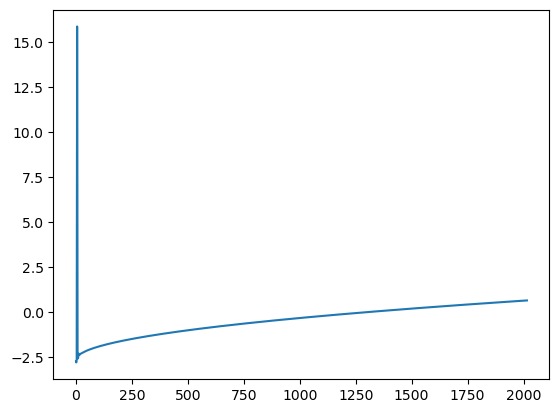

In [95]:
import matplotlib.pyplot as plt

plt.plot(exp.dataloader.train_dataset.scaled_data[:, :])